In [8]:
import numpy as np
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.utils import to_categorical
import utilities
import random
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = np.genfromtxt("keras_RNN_D9A87.csv", delimiter=',', skip_header=1, names=['epoch','acc','loss','val_acc','val_loss'])

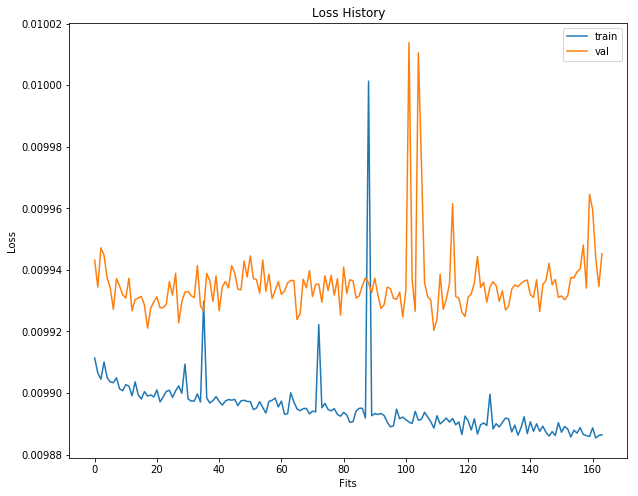

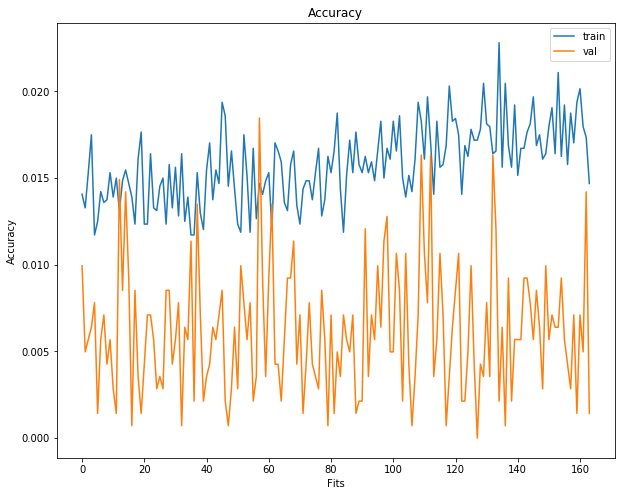

In [3]:
plt.plot(data['loss'],label="train")
plt.plot(data['val_loss'], label="val")
plt.title("Loss History")
plt.xlabel("Fits")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(data['acc'],label="train")
plt.plot(data['val_acc'], label="val")
plt.title("Accuracy")
plt.xlabel("Fits")
plt.ylabel("Accuracy")
plt.legend()

In [4]:
# load data
mypath = "/home/Chelsea/tmp_cropped"
img_files = [os.path.join(mypath, f) for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath, f)))]
x_data, flows_data, y_data_orig = utilities.load_data(img_files)
# x_data is: [imu_data, v, d_raw[i_start:i_end,1:4]
imu_data = x_data[:,0:6]
y_data = np.reshape(y_data_orig, (y_data_orig.shape[0],1) )

cats, mean = utilities.discretize_outputs(y_data, 100) # 100 bins
cats = np.reshape(cats, (cats.shape[0],1))
print(cats.shape)
print(mean.shape)
y_data = cats
y_data = to_categorical(y_data)
print(y_data.shape)

print("flows_data.shape",flows_data.shape)
print("imu_data.shape", imu_data.shape)
print("y_data.shape", y_data.shape)
N_flows,H,W,C = flows_data.shape
N_imu, imu_H = imu_data.shape
N_y, y_h = y_data.shape

N_training = int(0.7*flows_data.shape[0])
N_validation = int(0.5*(flows_data.shape[0]- N_training))
N_test = flows_data.shape[0] - N_training - N_validation
print("N train:", N_training)
print("N val:", N_validation)
print("N test:", N_test)

Loading vector data
Loading image data
Preprocessing data
(9400, 1)
(100,)
(9400, 100)
flows_data.shape (9400, 48, 64, 2)
imu_data.shape (9400, 6)
y_data.shape (9400, 100)
N train: 6580
N val: 1410
N test: 1410


In [5]:
# load pretrained model and model weights from checkpoint file
# define model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import concatenate
from keras import losses
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

minibatch_dim = 32
sequence_length = 10 # really the sliding window backprop length. 
n_windows = 6

# placeholder for images
img_inputs = Input(batch_shape=(minibatch_dim,sequence_length,H,W,C)) # truly: (minibatch_dim, seq_len, H, W, C)
# process images
interm = TimeDistributed(Conv2D(64, 3, strides=2, padding='valid', data_format="channels_last", activation='relu'))(img_inputs)
#interm = TimeDistributed(MaxPooling2D(pool_size=(1,3), strides=(1,2), padding = 'valid'))(interm)
extracted_image_features =  TimeDistributed(Flatten())(interm)
# placeholder for imu data
imu_inputs = Input(batch_shape=(minibatch_dim,sequence_length, imu_H))
# process imu data
extracted_imu_features = TimeDistributed(Dense(32, activation='relu'))(imu_inputs)

# concat together
top_out = concatenate([extracted_image_features, extracted_imu_features])

# have data of shape: minibatchsize X seq_length X 22112 after other layers
out1 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(top_out)
out2 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(out1)
out3 = LSTM(512,activation='elu', unroll=True)(out2)
out4 = Dense(100)(out3)


# define model
model = Model(inputs=[img_inputs, imu_inputs], outputs=out4)

# LOAD THOSE WEIGHTS BABY
model.load_weights("weights.best.hdf5")

from keras.optimizers import Adam
optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

In [23]:
# do predictions
start_ind = 0
sequence_length = 10
batch_size = 32
raw_predicts = np.zeros((int(N_flows/10), 100)) # class scores for 100 classes
pred_ind = 0
while start_ind + sequence_length*batch_size < N_flows:
    x_img_batch, x_imu_batch, y_batch, start_ind = utilities.sample_indep_seq_batch(batch_size, sequence_length, flows_data, imu_data, y_data, start_ind=start_ind)
    raw_predicts[pred_ind:pred_ind+batch_size, :] = model.predict([x_img_batch, x_imu_batch], verbose=2, batch_size=batch_size)
    pred_ind += batch_size

In [37]:
class_predicts = np.argmax(raw_predicts, axis=-1)
err_predicts = mean[class_predicts]
err_predicts.shape

(940,)

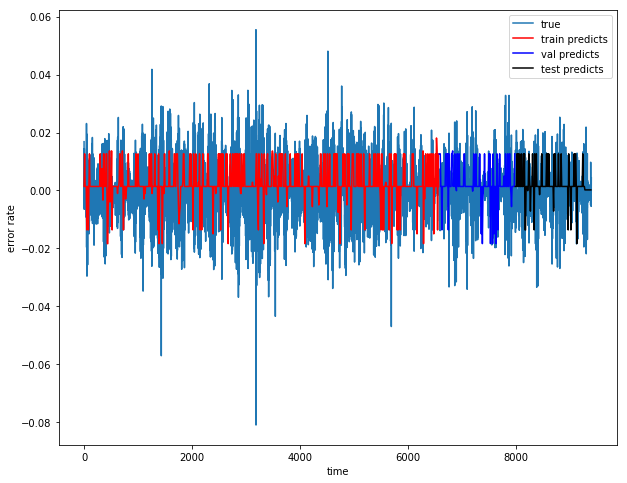

In [39]:
plt.figure()
plt.plot(y_data_orig, label="true")
plt.plot(range(0,N_training,10),err_predicts[0:int(N_training/10)], label="train predicts", color="red")
plt.plot(range(N_training,N_training+N_validation,10),err_predicts[int(N_training/10):int((N_training+N_validation)/10)], label="val predicts", color="blue")
plt.plot(range(N_training+N_validation,N_flows, 10),err_predicts[int((N_training+N_validation)/10):], label="test predicts", color="black")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

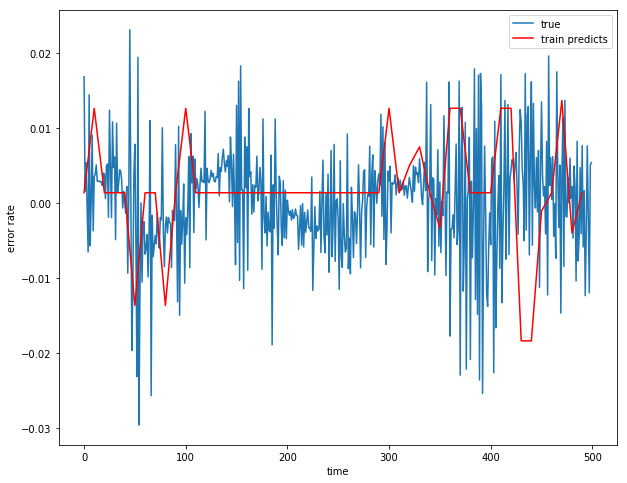

In [47]:
plt.figure()
plt.plot(y_data_orig[0:10*50], label="true")
plt.plot(range(0,N_training,10)[0:50],err_predicts[0:int(N_training/10)][0:50], label="train predicts", color="red")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

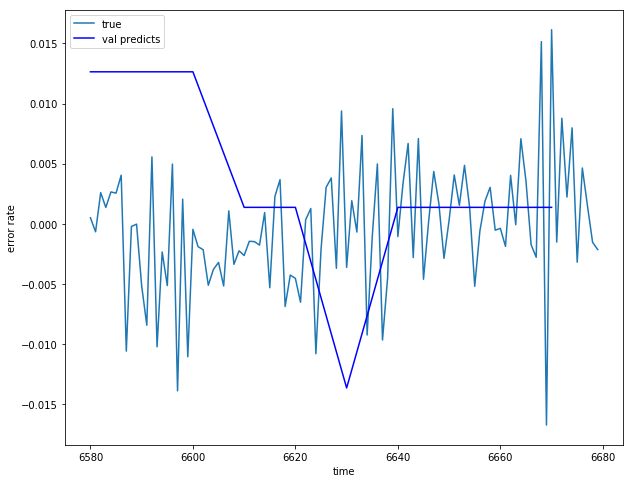

In [50]:
plt.figure()
plt.plot(range(N_training,N_training+N_validation)[0:10*10],y_data_orig[N_training:N_training+N_validation][0:10*10], label="true")
plt.plot(range(N_training,N_training+N_validation,10)[0:10],err_predicts[int(N_training/10):int((N_training+N_validation)/10)][0:10], label="val predicts", color="blue")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

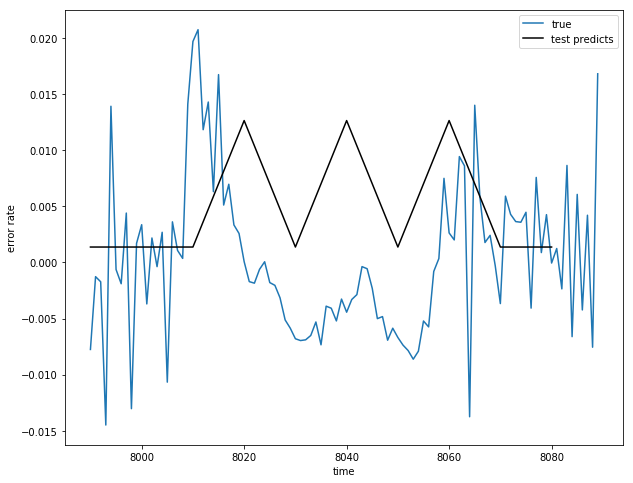

In [53]:
plt.figure()
plt.plot(range(N_training+N_validation,N_flows)[0:10*10], y_data_orig[N_training+N_validation:N_flows][0:10*10], label="true")
plt.plot(range(N_training+N_validation,N_flows, 10)[0:10],err_predicts[int((N_training+N_validation)/10):][0:10], label="test predicts", color="black")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()